In [23]:
import numpy as np
import time
import matplotlib.pyplot as plt
import PyMieScatt as ps
import subprocess
import math
import sys
import pandas as pd
import sklearn
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from scipy.optimize import minimize

indreal, indimg, sig = 1.5, 1E-1, 1.8 # ne pas modifier pour l'instant

lw, ms = 1, 0.02
sig_norm = 0.02  # Sigma de notre bruit gaussien jusqu'à 20%

df_BAE = np.array(pd.read_csv("BAElognorm.csv"))
df_diam = np.array(pd.read_csv("diam.csv"))

diam_entree = df_diam[0:714] # Charger les données diamètre

BAE_1064_532 = df_BAE[0:714,0] + np.random.normal(0, sig_norm, 714)
BAE_532_355 = df_BAE[0:714,1] + np.random.normal(0, sig_norm, 714)
BAE_1064_355 = df_BAE[0:714,2] + np.random.normal(0, sig_norm, 714)
BAEs = np.array([BAE_1064_532, BAE_532_355, BAE_1064_355]).T
print(np.shape(BAEs))

(714, 3)


In [24]:
def Separation_par_grad(BAEs, diam_entree):
    # Calculer la dérivée de BAEs
    x = np.linspace(diam_entree.min(), diam_entree.max(), len(BAEs))
    grad_BAEs = np.gradient(BAEs[:,:1], x, axis=0)

    # Trouver les indices où la dérivée change de signe et est positive
    sign_changes = np.where(np.diff(np.sign(grad_BAEs.squeeze())))[0]
    positive_grad = diam_entree[np.where(grad_BAEs > 0)[0]]

    # Extraire les diamètres correspondants
    diam_sign_changes = diam_entree[sign_changes]

    # Ajouter les bornes pour chaque intervalle de prédiction
    bounds = []
    for i in range(len(diam_sign_changes)-1):
        if i == len(diam_sign_changes)-2:
            bounds.append((diam_sign_changes[i+1], diam_entree.max()))
        else :
             bounds.append((diam_sign_changes[i], diam_sign_changes[i+1]))

    # Recomposition de l'espace des diamètres pour créer les intervales de la méthodes des 
    if diam_entree.min() < bounds[0][0]:
        new_bound = np.array([diam_entree.min(), bounds[0][0]])
        bounds = np.concatenate((new_bound.reshape(1, -1), bounds), axis=0)

    if diam_entree.max() > bounds[-1][1]:
        new_bound = np.array([bounds[-1][1], diam_entree.max()])
        bounds = np.concatenate((bounds, new_bound.reshape(1, -1)), axis=0)

    for i in range(len(bounds)-1):
        if bounds[i][1] != bounds[i+1][0]:
            new_bound = np.array([bounds[i][1], bounds[i+1][0]])
            bounds = np.concatenate((bounds[:i+1], new_bound.reshape(1, -1), bounds[i+1:]), axis=0)
    bounds_new = [] 
    for i in range(len(bounds)):
        row = []
        for j in range(len(bounds[i])):
            if isinstance(bounds[i][j], np.ndarray):
                row.append(bounds[i][j][0])
            else:
                row.append(bounds[i][j])
        bounds_new.append(row)
    
    return grad_BAEs, positive_grad, bounds_new

bounds_new = Separation_par_grad(BAEs, diam_entree)[2]

#print(bounds_new)

C:\Users\thoma\AppData\Local\Temp\ipykernel_3784\2255236515.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  new_bound = np.array([diam_entree.min(), bounds[0][0]])
<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
start = time.time()
# Diviser les données en deux parties avec la même proportion de test
X_train1, X_test1, y_train1, y_test1 = train_test_split(BAEs[:,:1], diam_entree, test_size=0.3, random_state=42)

# Instancier et entraîner le modèle KNN pour la première partie des données
knn = KNeighborsRegressor(n_neighbors=10)
knn.fit(X_train1, y_train1)
diam_pred1 = knn.predict(X_test1)

# Instancier et entraîner un modèle de régression linéaire pour la première partie des données
reg_lin = LinearRegression()
reg_lin.fit(X_train1, y_train1)
diam_pred2 = reg_lin.predict(X_test1)


def weighted_mse(weights, bounds_new):
    # Prédire le diamètre en combinant les prédictions des deux modèles avec les poids donnés
    diam_pred = np.zeros(diam_pred1.shape[0])
    for i in range(diam_pred1.shape[0]):
        # Trouver l'intervalle correspondant pour le point actuel
        for j in range(len(bounds_new)):
            if y_test1[i] >= bounds_new[j][0] and y_test1[i] < bounds_new[j][1]:
                # Calculer la prédiction pour cet intervalle avec les poids correspondants
                
                idx = j*2
                diam_pred[i] = (weights[idx] * diam_pred1[i]) + (weights[idx+1] * diam_pred2[i])
                break
    # Calculer le MSE des prédictions combinées
    mse = mean_squared_error(y_test1, diam_pred)
    return mse

# Définir les contraintes pour les poids des modèles
cons = []
for i in range(0, 2*len(bounds_new)-1, 2):
    cons.append({'type': 'ineq', 'fun': lambda x, i=i: x[i]+x[i+1]-1})

# Définir les bornes des poids des modèles
bnds = [(0, 1)]*(2*len(bounds_new))

# Initialiser les poids avec des valeurs égales
init_weights = np.full((2*len(bounds_new),), 0.5)
# Minimiser le MSE en ajustant les poids des modèles
res = minimize(weighted_mse, init_weights, bounds_new, method='Powell', bounds=bnds, constraints=cons)

# Récupérer les poids optimaux
opt_weights = res.x
#print(opt_weights)

def vote_ponderes(weights, bounds_new):
    # Prédire le diamètre en combinant les prédictions des deux modèles avec les poids donnés
    diam_pred = np.zeros(diam_pred1.shape[0])
    for i in range(diam_pred1.shape[0]):
        # Trouver l'intervalle correspondant pour le point actuel
        for j in range(len(bounds_new)):
            if y_test1[i] >= bounds_new[j][0] and y_test1[i] < bounds_new[j][1]:
                # Calculer la prédiction pour cet intervalle avec les poids correspondants
                idx = j*2
                diam_pred[i] = (weights[idx] * diam_pred1[i]) + (weights[idx+1] * diam_pred2[i])
                break
    return diam_pred

diam_pred = vote_ponderes(opt_weights, bounds_new)

end = time.time()
tmps = end - start

C:\Users\thoma\anaconda3\envs\tf\lib\site-packages\scipy\optimize\_minimize.py:565: RuntimeWarning: Method Powell cannot handle constraints.
  warn('Method %s cannot handle constraints.' % method,


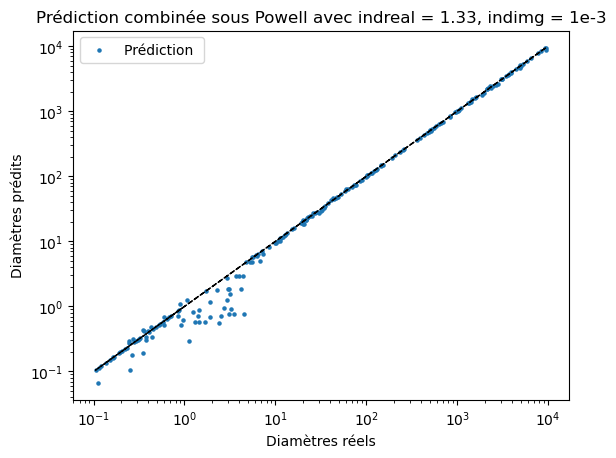

In [22]:
# Afficher les résultats de la prédiction combinée

#print(r2, mae, mse, tmps)
plt.scatter(y_test1, diam_pred, s=5, label="Prédiction ")
plt.plot(y_test1, y_test1, 'k--', lw=1,)
plt.xlabel('Diamètres réels')
plt.ylabel('Diamètres prédits')
plt.xscale("log", base = 10)
plt.yscale("log", base = 10)
plt.title('Prédiction combinée sous Powell avec indreal = 1.5, indimg = 1e-1')
plt.legend()
plt.show()
#print(bounds_new, "\n")
#print(opt_weights)

86206.40136476306 240.61090735572054 0.9722689090846157
7172.287969827652


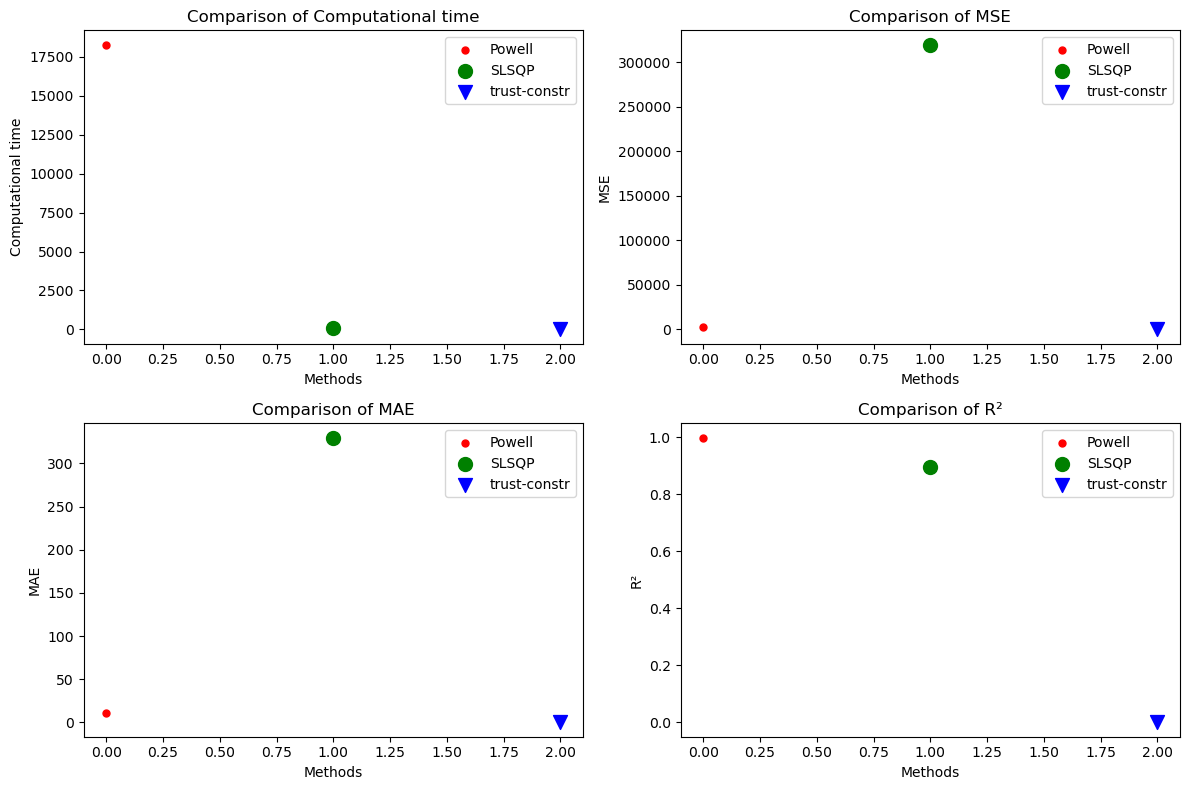

In [33]:

print( mean_squared_error(y_test1, diam_pred), mean_absolute_error(y_test1, diam_pred), r2_score(y_test1, diam_pred))
print(tmps)

tmps_values = [18271.281378746033, 79.69434189796448, 0, 7172.287969827652]
train_mse_values = [2704.9518309030136, 320070.8940285942 , 0, 86206.40136476306]
train_r2_values = [0.9991298643261176, 0.8970387938580242, 0, 0.9722689090846157, ]
train_mae_values = [11.549715156787794, 329.9899638483735 , 0, 240.61090735572054 ]


# Graphiques pour les différentes métriques
metrics = ['tmps', 'train_mse', 'train_mae', 'train_r2']
names = ["Computational time", "MSE", "MAE","R²"]
methods = ['Powell', 'SLSQP', 'trust-constr', 'Nelder-Mead']
colors = ['red', 'green', 'blue']
markers = ['.', 'o', 'v', '^']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

for i, ax in enumerate(axes.ravel()):
    for j, method in enumerate(methods):
        ax.scatter(j, eval(metrics[i]+'_values')[j], marker=markers[j], color=colors[j], label=method, s=100)
    ax.set_xlabel('Methods')
    ax.set_ylabel(names[i])
    ax.set_title(f"Comparison of {names[i]}")
    ax.legend()

plt.tight_layout()
plt.show()